In [9]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset

In [10]:
true_df = pd.read_csv("/content/True.csv")
fake_df = pd.read_csv("/content/Fake.csv")



In [11]:
print("True dataset shape:", true_df.shape)
print("Fake dataset shape:", fake_df.shape)

True dataset shape: (21417, 4)
Fake dataset shape: (23481, 4)


In [12]:
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [13]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [14]:
true_df["label"] = 1
fake_df["label"] = 0

Merge two dataset


In [15]:
df = pd.concat([true_df, fake_df], axis=0).reset_index(drop=True)

In [16]:
print(df.shape)

(44898, 5)


In [17]:
df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


/tmp/ipython-input-930643103.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=df, palette="Set2")


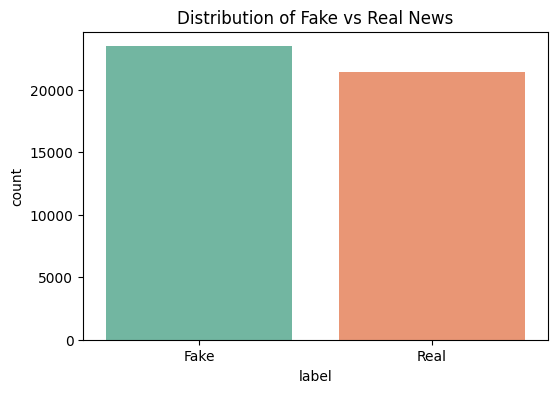

In [18]:
plt.figure(figsize=(6,4))
sns.countplot(x="label", data=df, palette="Set2")
plt.xticks([0,1], ["Fake", "Real"])
plt.title("Distribution of Fake vs Real News")
plt.show()

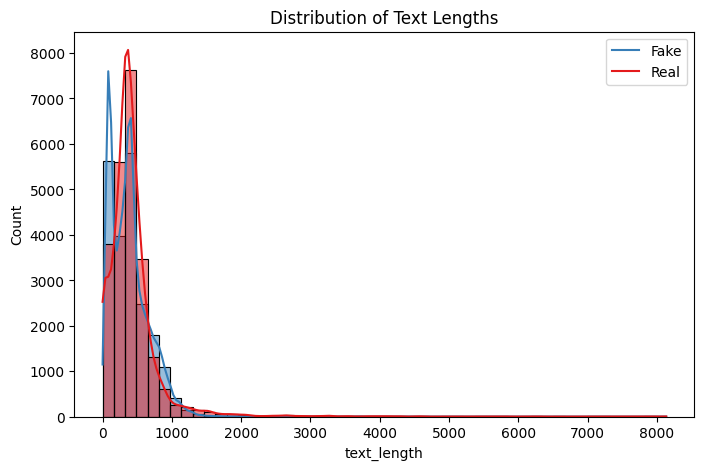

In [19]:
df["text_length"] = df["text"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8,5))
sns.histplot(data=df, x="text_length", hue="label", bins=50, kde=True, palette="Set1")
plt.legend(labels=["Fake","Real"])
plt.title("Distribution of Text Lengths")
plt.show()

In [20]:
df["content"] = df["title"] + " " + df["text"]

df = df[["content", "label"]]

In [21]:
df.head()

,content,label
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1


In [22]:
from sklearn.model_selection import train_test_split

train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df["content"], df["label"], test_size=0.3, random_state=42
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)

print("Train size:", len(train_texts))
print("Validation size:", len(val_texts))
print("Test size:", len(test_texts))

Train size: 31428
Validation size: 6735
Test size: 6735


In [23]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=256)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=256)


In [24]:
import torch
from torch.utils.data import Dataset

class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = NewsDataset(train_encodings, list(train_labels))
val_dataset = NewsDataset(val_encodings, list(val_labels))
test_dataset = NewsDataset(test_encodings, list(test_labels))


In [26]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [27]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset

class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
)
training_args = TrainingArguments(
    output_dir="./results",
    save_strategy="steps",
    save_steps=500,
    logging_dir="./logs",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    learning_rate=2e-5,
    weight_decay=0.01
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-722215109.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.039400
1000,0.005300
1500,0.004500
2000,0.002700
2500,0.000300
3000,0.000000
3500,0.001400


TrainOutput(global_step=3930, training_loss=0.006830784933447231, metrics={'train_runtime': 2858.8727, 'train_samples_per_second': 21.986, 'train_steps_per_second': 1.375, 'total_flos': 8269054247854080.0, 'train_loss': 0.006830784933447231, 'epoch': 2.0})

In [28]:
trainer.save_model("./results")

In [29]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("./results")
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [30]:
import gradio as gr
from transformers import BertForSequenceClassification, BertTokenizer
import torch

model = BertForSequenceClassification.from_pretrained("./results")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model.eval()

label_map = {1: "Real", 0: "Fake"}

def predict_news(text):
    encoding = tokenizer(
        text,
        truncation=True,
        padding=True,
        max_length=256,
        return_tensors="pt"
    )
    with torch.no_grad():
        outputs = model(**encoding)
    logits = outputs.logits
    predicted_class_id = torch.argmax(logits, dim=1).item()
    return label_map[predicted_class_id]


interface = gr.Interface(
    fn=predict_news,
    inputs=gr.Textbox(lines=4, placeholder="Enter news text here..."),
    outputs="text",
    title="Fake News Detector",
    description="Enter any news text to check if it is Fake or Real."
)

interface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e5a274f55b4ad93ae7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [1]:
trainer.save_model("./results")
tokenizer.save_pretrained("./results")


NameError: name 'trainer' is not defined